El servicio de venta de autos usados Rusty Bargain está desarrollando una aplicación para atraer nuevos clientes. Gracias a esa app, puedes averiguar rápidamente el valor de mercado de tu coche. Tienes acceso al historial: especificaciones técnicas, versiones de equipamiento y precios. Tienes que crear un modelo que determine el valor de mercado.
A Rusty Bargain le interesa:
- la calidad de la predicción;
- la velocidad de la predicción;
- el tiempo requerido para el entrenamiento

## Preparación de datos

### Inicialización

In [1]:
# cargar librerías

import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MaxAbsScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
import seaborn as sns
import math
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import sklearn.linear_model
import sklearn.metrics
import sklearn.neighbors
import sklearn.preprocessing
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDRegressor
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingRegressor, BaggingClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV, KFold
from IPython.display import display
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor 
import lightgbm as lgb 


In [2]:
# cargar datos

df = pd.read_csv('/datasets/car_data.csv')

In [3]:
data_df = df.copy()

In [4]:
data_df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


In [5]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Se encuentran datos faltantes en model, vehicletype, fueltype, notrepaired, gearbox

Veré si hay duplicados para eliminarlos.

In [6]:
print(data_df.duplicated().sum())

262


In [7]:
data_df.drop_duplicates(inplace= True)

In [8]:
# luego eliminar las columnas que no me sirvan para entrenar el modelo de clasificación


data_df.drop(['DateCrawled', 'NumberOfPictures', 'DateCreated', 'LastSeen'], axis=1, inplace=True)
print(data_df)

        Price  VehicleType  RegistrationYear Gearbox  Power        Model  \
0         480          NaN              1993  manual      0         golf   
1       18300        coupe              2011  manual    190          NaN   
2        9800          suv              2004    auto    163        grand   
3        1500        small              2001  manual     75         golf   
4        3600        small              2008  manual     69        fabia   
...       ...          ...               ...     ...    ...          ...   
354364      0          NaN              2005  manual      0         colt   
354365   2200          NaN              2005     NaN      0          NaN   
354366   1199  convertible              2000    auto    101       fortwo   
354367   9200          bus              1996  manual    102  transporter   
354368   3400        wagon              2002  manual    100         golf   

        Mileage  RegistrationMonth  FuelType           Brand NotRepaired  \
0        15

Haciendo featuring engineering tomé en cuenta que la fecha de subida de la información sirve como referencia de los datos pero realmente no da información al modelo, así que decidí eliminarla, el mes de registro tampoco lo consideré muy reelevante 
al ver los valores de la columna de el número de fotos vi que todos los valores eran 0 así que elegí eliminarla también.



In [9]:
# Descripción de los datos

data_df.describe()

,Price,RegistrationYear,Power,Mileage,RegistrationMonth,PostalCode
count,354107.000000,354107.000000,354107.000000,354107.000000,354107.000000,354107.000000
mean,4416.433287,2004.235355,110.089651,128211.811684,5.714182,50507.145030
std,4514.338584,90.261168,189.914972,37906.590101,3.726682,25784.212094
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,49406.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,99998.000000


In [10]:
# Este formato muestra mejor los valores ausentes.
data_df.isnull().sum()

Price                    0
VehicleType          37484
RegistrationYear         0
Gearbox              19830
Power                    0
Model                19701
Mileage                  0
RegistrationMonth        0
FuelType             32889
Brand                    0
NotRepaired          71145
PostalCode               0
dtype: int64

<AxesSubplot:xlabel='Price', ylabel='Count'>

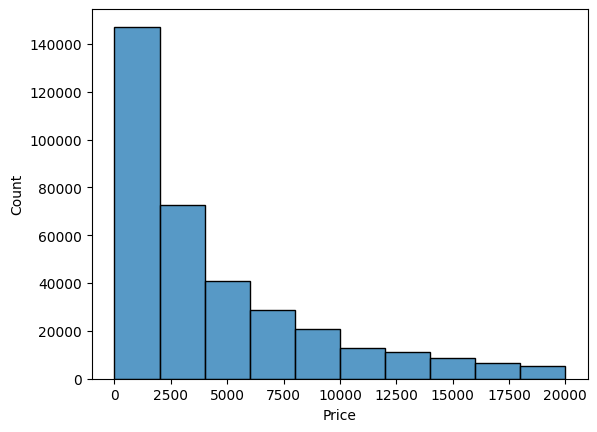

In [11]:
# Visualicemos en donde se encuentra la mayoría de los precios

sns.histplot(data_df['Price'], bins=10)

In [12]:
# Crear un imputer
knn_imputer = KNNImputer(n_neighbors=2)

# Definir columnas numéricas
numerical_cols_df = data_df.select_dtypes(include=['number'])
numerical_cols = numerical_cols_df.columns.tolist()

# Definir las columnas categóricas
cat_cols_df = data_df.select_dtypes(include=['object'])
cat_cols = cat_cols_df.columns.tolist()

In [13]:
# Definir la funcion para imputar los nuevos datos
def num_knn_impute(data, cols, imputer):
    data = data[cols]
    data_imputed = pd.DataFrame(imputer.fit_transform(data))
    data_imputed.columns = data.columns
    return data_imputed

# Usar la función para imputar valores numéricos knn
num_test_data_imputed = num_knn_impute(data_df, numerical_cols, knn_imputer)


In [14]:
# Obtener las columnas numéricas del dataframe
num_cols_df = data_df[numerical_cols].reset_index(drop=True)
# Seleccionar las filas con valores ausentes e imprimir head
missing_data_df = num_cols_df[num_cols_df.isna().any(axis=1)]
missing_data_df.head()

,Price,RegistrationYear,Power,Mileage,RegistrationMonth,PostalCode


In [15]:
# Veamos el registro después de la imputación
samples = missing_data_df.index.to_list()
num_test_data_imputed.loc[samples].head()

,Price,RegistrationYear,Power,Mileage,RegistrationMonth,PostalCode


In [16]:
# Crear imputador imputer
simple_imputer = SimpleImputer(strategy='most_frequent')

# Definir la funcion para imputar características categóricas con simple imputer
def cat_simple_imputer(data, cols, imputer):
    data = data[cols]
    data_imputed = pd.DataFrame(imputer.fit_transform(data))
    data_imputed.columns = data.columns
    return data_imputed

# Ejecutar la función para imputar los valores categóricos ausentes
cat_test_data_imputed = cat_simple_imputer(data_df, cat_cols, simple_imputer)

In [17]:
# Obtener las columnas numéricas del df
cat_cols_df = data_df[cat_cols].reset_index(drop=True)
# Seleccionar filas con valores ausentes e imprimir head
missing_cat_data_df = cat_cols_df[num_cols_df.isna().any(axis=1)]
missing_cat_data_df.head()

,VehicleType,Gearbox,Model,FuelType,Brand,NotRepaired


In [18]:
# Mostrar luego de imputar
samples = missing_cat_data_df.index.to_list()
cat_test_data_imputed.loc[samples].head()

,VehicleType,Gearbox,Model,FuelType,Brand,NotRepaired


In [19]:
# Juntar los dataframes
train_imputed_df = pd.concat([num_test_data_imputed, cat_test_data_imputed], axis=1)
# imprimir head
train_imputed_df.head()

,Price,RegistrationYear,Power,Mileage,RegistrationMonth,PostalCode,VehicleType,Gearbox,Model,FuelType,Brand,NotRepaired
0,480.0,1993.0,0.0,150000.0,0.0,70435.0,sedan,manual,golf,petrol,volkswagen,no
1,18300.0,2011.0,190.0,125000.0,5.0,66954.0,coupe,manual,golf,gasoline,audi,yes
2,9800.0,2004.0,163.0,125000.0,8.0,90480.0,suv,auto,grand,gasoline,jeep,no
3,1500.0,2001.0,75.0,150000.0,6.0,91074.0,small,manual,golf,petrol,volkswagen,no
4,3600.0,2008.0,69.0,90000.0,7.0,60437.0,small,manual,fabia,gasoline,skoda,no


In [20]:
#checar valores ausentes luego de imputar

train_imputed_df.isnull().sum()

Price                0
RegistrationYear     0
Power                0
Mileage              0
RegistrationMonth    0
PostalCode           0
VehicleType          0
Gearbox              0
Model                0
FuelType             0
Brand                0
NotRepaired          0
dtype: int64

In [21]:
# Valores únicos de cada categoría para retirar las columnas con menos correlación y así evitar que muera el kernel 

cat_test_data_imputed.nunique()

VehicleType      8
Gearbox          2
Model          250
FuelType         7
Brand           40
NotRepaired      2
dtype: int64

## Entrenamiento del modelo 

In [22]:
# Veamos los valores

train_imputed_df.head()


,Price,RegistrationYear,Power,Mileage,RegistrationMonth,PostalCode,VehicleType,Gearbox,Model,FuelType,Brand,NotRepaired
0,480.0,1993.0,0.0,150000.0,0.0,70435.0,sedan,manual,golf,petrol,volkswagen,no
1,18300.0,2011.0,190.0,125000.0,5.0,66954.0,coupe,manual,golf,gasoline,audi,yes
2,9800.0,2004.0,163.0,125000.0,8.0,90480.0,suv,auto,grand,gasoline,jeep,no
3,1500.0,2001.0,75.0,150000.0,6.0,91074.0,small,manual,golf,petrol,volkswagen,no
4,3600.0,2008.0,69.0,90000.0,7.0,60437.0,small,manual,fabia,gasoline,skoda,no


In [23]:
train_imputed_df.corr().sort_values(by='Price',ascending=False)


,Price,RegistrationYear,Power,Mileage,RegistrationMonth,PostalCode
Price,1.000000,0.026907,0.158831,-0.333144,0.110605,0.076034
Power,0.158831,-0.000828,1.000000,0.023993,0.043370,0.021657
RegistrationMonth,0.110605,-0.011624,0.043370,0.009627,1.000000,0.014063
PostalCode,0.076034,-0.003458,0.021657,-0.007675,0.014063,1.000000
RegistrationYear,0.026907,1.000000,-0.000828,-0.053450,-0.011624,-0.003458
Mileage,-0.333144,-0.053450,0.023993,1.000000,0.009627,-0.007675


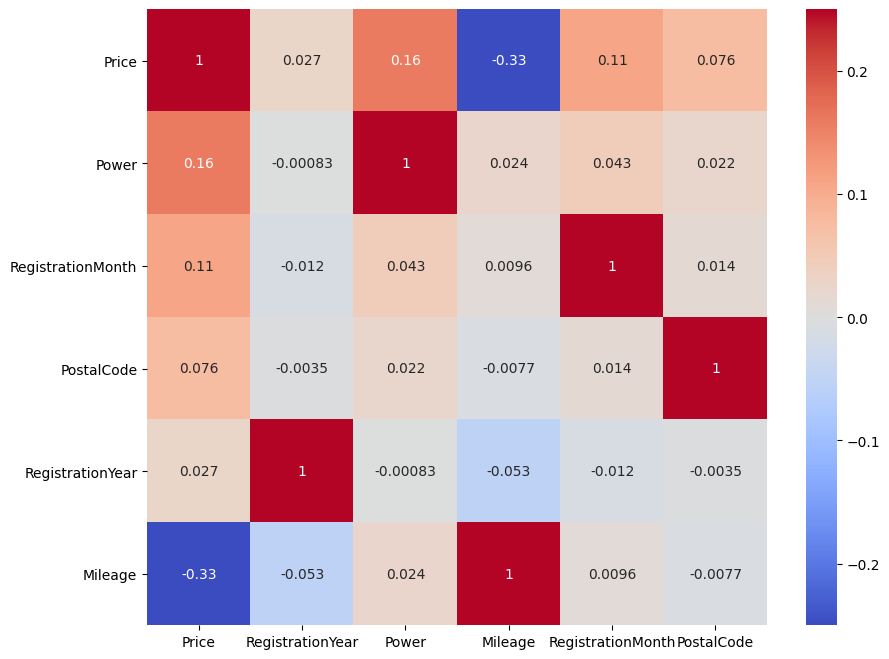

In [24]:
# Veamos las correlaciones más importantes conforme al precio


fig, ax = plt.subplots(figsize=(10, 8)) 

corr_matrix = train_imputed_df.corr().sort_values(by='Price', ascending=False)

sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, vmax=0.25, vmin=-0.25)
plt.show()

No era lo que esperaba, sin embargo las columnas que más correlacionados están con el precio son potencia, mes de regristro, código postal, año de registro y todas las demás como la marca o el modelo no tienen ninguna correlación relevante.

In [25]:
# Calcular los percentiles 33, 66 y 100 para la estratificación

percentiles = [0.33, 0.66, 1]
percentile_values = train_imputed_df['Price'].quantile(percentiles)

print(percentile_values) 

0.33     1500.0
0.66     4600.0
1.00    20000.0
Name: Price, dtype: float64


In [26]:
# Convertiré las columnas con opciones binarias en 0 y 1

binary_cols = ['Gearbox', 'NotRepaired']

# Definir valores
mapping = {'Yes': 1,
           'No': 0,
           'yes': 1,
           'no': 0,
           'manual': 1,
           'auto': 0,
           }

# Definir funcion para cambiar valores
def binarise_values(data, cols, map):
    for col in cols:
        data[col] = data[col].map(map)
    return data

# Llamar a la función
data_ohe = binarise_values(train_imputed_df, binary_cols, mapping)

data_ohe.head()

,Price,RegistrationYear,Power,Mileage,RegistrationMonth,PostalCode,VehicleType,Gearbox,Model,FuelType,Brand,NotRepaired
0,480.0,1993.0,0.0,150000.0,0.0,70435.0,sedan,1,golf,petrol,volkswagen,0
1,18300.0,2011.0,190.0,125000.0,5.0,66954.0,coupe,1,golf,gasoline,audi,1
2,9800.0,2004.0,163.0,125000.0,8.0,90480.0,suv,0,grand,gasoline,jeep,0
3,1500.0,2001.0,75.0,150000.0,6.0,91074.0,small,1,golf,petrol,volkswagen,0
4,3600.0,2008.0,69.0,90000.0,7.0,60437.0,small,1,fabia,gasoline,skoda,0


In [27]:
# Crear una nueva columna para las categorías basadas en los percentiles

def categorize(price):
    if price <= percentile_values[0.33]:
        return 'low'
    elif price <= percentile_values[0.66]:
        return 'medium'
    else:
        return 'high'
# Elimino estas columnas para que el kernel no muera   
data_ohe = data_ohe.drop(columns=['NotRepaired', 'Gearbox', 'FuelType', 'Model'])

# Así queda la información
data_ohe.head()

,Price,RegistrationYear,Power,Mileage,RegistrationMonth,PostalCode,VehicleType,Brand
0,480.0,1993.0,0.0,150000.0,0.0,70435.0,sedan,volkswagen
1,18300.0,2011.0,190.0,125000.0,5.0,66954.0,coupe,audi
2,9800.0,2004.0,163.0,125000.0,8.0,90480.0,suv,jeep
3,1500.0,2001.0,75.0,150000.0,6.0,91074.0,small,volkswagen
4,3600.0,2008.0,69.0,90000.0,7.0,60437.0,small,skoda


In [28]:
# Ahora codificamos la información para usar los datos en los modelos

data_ohe = pd.get_dummies(data_ohe, drop_first=True)


    
data_ohe['category'] = data_ohe['Price'].apply(categorize)

In [29]:
# Realizar el split estratificado

# features
x = data_ohe.drop(columns=['Price', 'category'])
# target
y = data_ohe['Price']

stratify_col = data_ohe['category']


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=stratify_col, random_state=42)



In [30]:
# Estandarizamos los datos
  
# StandardScaler para escalar los datos de entrenamiento y prueba 
scaler = StandardScaler() 
# Entreno con los datos de entrenamiento
scaler.fit(x_train) 
# Transformo ambos conjuntos 
x_train = scaler.transform(x_train) 
x_test = scaler.transform(x_test) 

In [31]:
# Veamos el balance de las categorías

data_ohe['category'].value_counts()

low       121680
high      120172
medium    112255
Name: category, dtype: int64

In [32]:
# Cómo queda la información

print(x_train)

[[-9.84367335e-02  2.55281036e-04  5.74855728e-01 ... -4.02413281e-02
   1.89834534e+00 -9.59266879e-02]
 [-7.73722880e-02 -1.87540022e-01  5.74855728e-01 ... -4.02413281e-02
   1.89834534e+00 -9.59266879e-02]
 [-1.08968956e-01  3.06093346e-01  5.74855728e-01 ... -4.02413281e-02
  -5.26774544e-01 -9.59266879e-02]
 ...
 [ 4.90143847e-02 -3.00217204e-01 -2.06151358e+00 ... -4.02413281e-02
  -5.26774544e-01 -9.59266879e-02]
 [-1.41789516e-02  3.22190086e-01  5.74855728e-01 ... -4.02413281e-02
  -5.26774544e-01 -9.59266879e-02]
 [-1.19501179e-01 -1.71443282e-01 -8.42365992e-02 ... -4.02413281e-02
  -5.26774544e-01 -9.59266879e-02]]


Utilizaré la métrica RECM para evaluar los modelos.

Usaré regresión lineal para una prueba de cordura, bosque aleatorio, LightGBM con ajuste de hiperparámetros, CatBoost y XGBoost con ajuste de hiperparámetros (opcional).

Usé el comando especial para encontrar el tiempo de ejecución del código de celda en Jupyter Notebook. Cambié solo algunos parámetros del modelo.

In [33]:
# Prueba de cordura

model = LinearRegression()
model.fit(x_train, y_train)
val_t_predictions = model.predict(x_test)
mse_t = mse(y_test, val_t_predictions)
%time print("RECM test = ", mse_t ** 0.5 )

RECM test =  3677.06446661357
CPU times: user 1.13 ms, sys: 151 µs, total: 1.29 ms
Wall time: 325 µs


In [34]:
# XGBRegressor

# Usé estos hiperparámetros pero los quité porque resulta más error con ellos
# learning_rate=0.1, max_depth=6, n_estimators=100, min_child_weight=1, subsample=0.8, colsample_bytree=0.8, gamma=0,
# reg_alpha=0, reg_lambda=1,  objective='reg:squarederror'

model = XGBRegressor()

# Entrenar el modelo con el conjunto de entrenamiento. 

model.fit(x_train, y_train)

# Hacer predicciones con los datos de prueba junto con su tiempo de ejecución. 

%time val_t_predictions = model.predict(x_test)
mse_t = mse(y_test, val_t_predictions)
print("RECM test = ", mse_t ** 0.5 )

CPU times: user 265 ms, sys: 0 ns, total: 265 ms
Wall time: 221 ms
RECM test =  1903.8591297098587


In [35]:

rf = RandomForestRegressor(random_state=54321)

# Definir la cuadrícula de parámetros
param_grid = {
    'n_estimators': range(30, 51, 10),
    'max_depth': range(7, 11)
}

# Configurar GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# Entrenar el modelo con GridSearchCV
grid_search.fit(x_train, y_train)

# Obtener los mejores parámetros
print("Mejores parámetros:", grid_search.best_params_)

# Predecir en el conjunto de prueba y tiempo de ejecución
%time y_pred = grid_search.best_estimator_.predict(x_test)

# Evaluar el modelo
mse_t = mse(y_test, y_pred)
rmse = mse_t ** 0.5
print("RMSE en el conjunto de prueba:", rmse)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END .......................max_depth=7, n_estimators=30; total time=  11.1s
[CV] END .......................max_depth=7, n_estimators=30; total time=   9.9s
[CV] END .......................max_depth=7, n_estimators=30; total time=   9.8s
[CV] END .......................max_depth=7, n_estimators=40; total time=  13.1s
[CV] END .......................max_depth=7, n_estimators=40; total time=  13.1s
[CV] END .......................max_depth=7, n_estimators=40; total time=  13.2s
[CV] END .......................max_depth=7, n_estimators=50; total time=  16.4s
[CV] END .......................max_depth=7, n_estimators=50; total time=  16.4s
[CV] END .......................max_depth=7, n_estimators=50; total time=  16.4s
[CV] END .......................max_depth=8, n_estimators=30; total time=  11.0s
[CV] END .......................max_depth=8, n_estimators=30; total time=  10.9s
[CV] END .......................max_depth=8, n_e

In [36]:
# LightGBM

# Creé una instancia de LightGBM Regressor con recm. 
model = LGBMRegressor(learning_rate=0.1,
    num_leaves=31,
    max_depth=-1,
    n_estimators=100,
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.0,
    reg_lambda=0.0,
    metric='rmse') 
  
# Entrenar el modelo con el conjunto de entrenamiento. 
model.fit(x_train, y_train) 
  
# Hacer predicciones con los datos de prueba junto con su tiempo de ejecución. 
%time Y_test = model.predict(x_test) 

mse_t = mse(y_test, Y_test)
print("RECM test = ", mse_t ** 0.5 )

CPU times: user 398 ms, sys: 13 µs, total: 398 ms
Wall time: 393 ms
RECM test =  1955.7964686371718


In [37]:
# CatBoostRegressor

model = CatBoostRegressor(
    learning_rate=0.1,
    depth=6,
    iterations=500,
    l2_leaf_reg=3,
    border_count=254,
    subsample=0.8,
    rsm=0.8,
    loss_function='RMSE',
    verbose=0)

# Entrenar el modelo con el conjunto de entrenamiento. 

model.fit(x_train, y_train)

# Hacer predicciones con los datos de prueba junto con su tiempo de ejecución. 

%time val_t_predictions = model.predict(x_test)
mse_t = mse(y_test, val_t_predictions)
print("RECM test = ", mse_t ** 0.5 )

CPU times: user 24.8 ms, sys: 3.93 ms, total: 28.8 ms
Wall time: 28.8 ms
RECM test =  1924.8405578990166


## Análisis del modelo

Para determinar cuál de los cuatro modelos es el mejor para predecir el precio de coches usados, debes considerar principalmente las métricas de rendimiento, en este caso, el RMSE (Root Mean Squared Error o Error Cuadrático Medio) en el conjunto de prueba. El RMSE es una medida de precisión, donde un valor más bajo indica un mejor rendimiento del modelo. Además, puedes considerar los tiempos de CPU y tiempo de pared (Wall time), aunque generalmente la precisión del modelo es el factor más importante.

Aquí tienes un resumen de los resultados:

XGBRegressor

CPU times: 446 ms
Wall time: 412 ms
RMSE test: 1903.86
RandomForestRegressor

Mejores parámetros: {'max_depth': 10, 'n_estimators': 50}
CPU times: 406 ms
Wall time: 409 ms
RMSE test: 2085.16
LGBMRegressor

CPU times: 741 ms
Wall time: 789 ms
RMSE test: 1955.80
CatBoostRegressor

CPU times: 54.4 ms
Wall time: 54.5 ms
RMSE test: 1924.84
Análisis
RMSE: La métrica principal a considerar es el RMSE, ya que mide la precisión del modelo. Aquí, el modelo con el menor RMSE es el XGBRegressor (1903.86), seguido por el CatBoostRegressor (1924.84), LGBMRegressor (1955.80), y finalmente el RandomForestRegressor (2085.16).

Tiempos de CPU y Wall Time: Aunque no es la métrica principal, puede ser útil considerar los tiempos de ejecución, especialmente si planeas implementar el modelo en un entorno donde el tiempo de predicción es crítico. El CatBoostRegressor tiene el tiempo de ejecución más bajo, tanto en CPU como en Wall time.

Conclusión
El mejor modelo en términos de precisión es el XGBRegressor con el RMSE más bajo (1903.86). Sin embargo, si los tiempos de ejecución son una consideración importante y puedes aceptar un ligero aumento en el RMSE, el CatBoostRegressor es una opción muy eficiente y rápida, con un RMSE de 1924.84 y tiempos de ejecución muy bajos.

En resumen:

Mejor modelo basado en RMSE: XGBRegressor
Mejor modelo basado en tiempo de ejecución y buena precisión: CatBoostRegressor